# Analysis of the experiments

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import groupby
from functools import reduce
import operator
import numpy as np
import re
import os

In [2]:
class Experiment:
    @staticmethod
    def _preprocess_csv(df):
        # Synchronicity problems cause some experiment
        # runs have periods that don't start at 0. So
        # the periods interval must be shifted so that
        # all experiment runs start at 0.
        df.index = df.index.map(lambda t: t - np.min(df.index))

        # Columns that are not relative to the CPU usage
        # of the device must be removed from the calculation
        # of the total CPU usage for each time step
        cols_drop = ['Stack', 'Mbps'] + (['main'] if 'main' in df.columns else [])
        total_cpu_usage = np.sum(df.drop(cols_drop, axis=1), axis=1)

        df['CPU'] = df['wifi'].values / total_cpu_usage 
        return df[['CPU', 'Stack', 'Mbps']]

    def __init__(self, name: str, directory: str, reps_file_names: str):
        self.name = name
        reps = ([pd.read_csv(f'{directory}/{file_name}', index_col='Timestamp') for file_name in reps_file_names])
        self.repetitions = [Experiment._preprocess_csv(rep) for rep in reps]

    # Returns the time series obtained for a given metric in the experiment 
    #
    #   Arguments:
    #       metric: the metric of the time series
    def get_time_series(self, metric: str) -> np.array:
        return np.stack([rep[metric].values[0:352] for rep in self.repetitions], axis=1)

In [3]:
class ExperimentsSuite:
    def __init__(self, data_dir: str):
        runs = [file for file in os.listdir('./formated_data') if file[0] != '.']
        exps_file_names = {}
        for run in runs:
            if run[:6] in exps_file_names:
                exps_file_names[run[:6]].append(run)
            else:
                exps_file_names[run[:6]] = [run]
        self.experiments = {name: Experiment(name, data_dir, exps_file_names[name]) for name in exps_file_names}
        print(self.experiments)

    @staticmethod
    def _group_models(experiments):
        groups = {key: [] for key in set([experiment[:4] for experiment in experiments])} 
        for experiment in experiments:
            groups[experiment[:4]].append(experiment)
        return groups

    # Plots a a violin plot of a metric for all experiments and
    # returns a dict with the experiment id string and a pyplot figure.
    # 
    #   Arguments:
    #       metric: The metric that should be plotted
    #       mu: The metric unit of the metric
    def plot_experiments(self, metric, mu):
        key_map = {'AN': 'Without T800', 'A2': 'DT-12', 'AM': 'MLP', 'AL': 'LR', 'AS': 'SVM'}
        colors = ['indianred', 'limegreen', 'royalblue', 'yellow', 'black', '']
        x_ticks = np.arange(0, 175, 25)
        groupped_models = ExperimentsSuite._group_models(self.experiments.keys())
        subplots = [plt.subplots(1, 1, figsize=(6, 4)) for _ in groupped_models]
        figs, axis = list(zip(*subplots))
        for ax, group in zip(axis, groupped_models):
            names, points = list(zip(*sorted([(exp[4:6], np.ravel(self.experiments[exp].get_time_series(metric))) for exp in groupped_models[group]], key=lambda x: x[0])))
            print(group[:4])
            print(names)
            print([np.round(np.median(p), 2) for p in points])
            ax.violinplot(points, list(range(len(points))), showmedians=True)
            ax.set_xticks(list(range(len(names))))
            ax.set_xticklabels([key_map[name] for name in names])
            ax.set_xlabel('Models', fontsize=12)
            ax.set_ylabel(mu, fontsize=12)
            ax.set_title(group, fontsize=30)
            ax.tick_params(axis='x', labelsize=10)
            ax.grid(color='gainsboro', linestyle=':', linewidth=2)
        return {name: fig for name, fig in zip(groupped_models, figs)}
    
    def get_experiment(self, experiment_key):
        print(ExperimentsSuite._group_models(self.experiments.keys()))
        for experiment in ExperimentsSuite._group_models(self.experiments.keys())[experiment_key[:-2]]:
            if experiment.name == experiment_key[-2:]:
                return experiment
        
    

    # Returns the factor importances in an array. The first index
    # corresponds to the influence of the presence of the packet filter
    # on the ESP32. The second one corresponds to the influence of 
    # the bandwith of benign traffic sent to the device. The third one
    # is the influence of the presence of malicious packets on the
    # generated traffic. The fourth corresponds to the influence exerted
    # on the results by the combination of the presence of the packet filter
    # and the benign traffic bandwith. The fitfh is the influence of the 
    # presence of the packet filter together with the presence of malicious
    # packets. The sixth is the influence of the bandwith together with the
    # presence of malicious data. The seventh is the influence of all the
    # factors combined. At last, the eigth is the experimental error.
    #
    # Argumetns:
    #   model: id of the machine learning model used in the experiment under analysis.
    #   aggregate: boolean value that controls wether to take the mean
    #       value of the metrics across all the machine learning models
    #       or to consider a single model.
    #
    #
    def get_factors_importance(self, model, agregate=False):
        levels = ['I0M0AN', 'I0M1AN', 'I1M0AN', 'I1M1AN', f'I0M0A{model}', f'I0M1A{model}', f'I1M0A{model}', f'I1M1A{model}']
        encoded_A_levels = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
        encoded_I_levels = np.array([-1, -1, 1, 1, -1, -1, 1, 1])
        encoded_M_levels = np.array([1, -1, 1, -1, 1, -1, 1, -1])
        first_column = np.ones_like(encoded_I_levels)
        second_column = encoded_A_levels
        third_column = encoded_I_levels
        fourth_column = encoded_M_levels
        fith_column = encoded_A_levels * encoded_I_levels
        sixth_column = encoded_A_levels * encoded_M_levels
        seventh_column = encoded_I_levels * encoded_M_levels
        eigth_column = encoded_A_levels * encoded_I_levels * encoded_M_levels
        X = np.stack([first_column, second_column, third_column, fourth_column, fith_column, sixth_column, seventh_column, eigth_column], axis=1)
        all_models = ['N', 'M', '2', 'L', 'S']
        if agregate:
            all_levels = [[f'I0M0A{model}', f'I0M1A{model}', f'I1M0A{model}', f'I1M1A{model}'] for model in all_models]
            head = all_levels[0]
            aux = np.array([[self.experiments[level].get_time_series('CPU') for level in levels] for levels in all_levels[1:]])
            aux = np.mean(aux, axis=0)
            cpu_series = np.concatenate([np.array([self.experiments[level].get_time_series('CPU') for level in head]), aux])
        else:
            cpu_series = np.array([self.experiments[level].get_time_series('CPU') for level in levels])
        print(cpu_series.shape)
        cpu_vals = np.mean(cpu_series, axis=1)
        print(cpu_vals.shape)
        mean_cpus = np.mean(cpu_vals, axis=-1)
        print(mean_cpus.shape)
        system_solutions = np.linalg.solve(X, mean_cpus)
        errors = cpu_vals - np.expand_dims(mean_cpus, axis=-1)
        squared_errors = np.square(errors)
        squared_system_solutions = np.square(system_solutions)
        squared_cpus = np.square(cpu_vals)
        SSY = np.sum(squared_cpus)
        SSE = np.sum(squared_errors)
        SSqs = 8 * 30 * squared_system_solutions
        SST = SSY - SSqs[0]
        print(SST)
        print(SSqs[1:])
        
        importances = (np.concatenate([SSqs[1:], np.expand_dims(SSE, axis=0)]) / np.expand_dims(SST, axis=0)).T
        return importances

In [4]:
experiments_suite = ExperimentsSuite('./formated_data')

{'I1M0AM': <__main__.Experiment object at 0x7ff1272dab60>, 'I1M0AS': <__main__.Experiment object at 0x7ff1272dba00>, 'I0M0AN': <__main__.Experiment object at 0x7ff1272dab30>, 'I0M0A2': <__main__.Experiment object at 0x7ff127028100>, 'I1M1AN': <__main__.Experiment object at 0x7ff1272d9cc0>, 'I0M1AM': <__main__.Experiment object at 0x7ff1270285b0>, 'I1M1A2': <__main__.Experiment object at 0x7ff17eea0c40>, 'I1M1AM': <__main__.Experiment object at 0x7ff17eea0c10>, 'I1M0A2': <__main__.Experiment object at 0x7ff1272d9510>, 'I0M1AL': <__main__.Experiment object at 0x7ff17eea0d90>, 'I1M0AL': <__main__.Experiment object at 0x7ff1270289d0>, 'I0M0AS': <__main__.Experiment object at 0x7ff1272d8490>, 'I0M1A2': <__main__.Experiment object at 0x7ff126f39e40>, 'I0M0AL': <__main__.Experiment object at 0x7ff126f3b5e0>, 'I1M0AN': <__main__.Experiment object at 0x7ff17ee5a230>, 'I1M1AS': <__main__.Experiment object at 0x7ff127051ba0>, 'I0M1AS': <__main__.Experiment object at 0x7ff127111cc0>, 'I1M1AL': <__

## Metrics violin plots

In [5]:

groupped_models = ExperimentsSuite._group_models(experiments_suite.experiments.keys())
d = dict.fromkeys(['Model', 'CPU', 'Stack', 'Mbps'])
names, cpu_points, stack_points, rede_points = list(zip(*[(exp, np.ravel(experiments_suite.experiments[exp].get_time_series('CPU')),\
                                                    np.ravel(experiments_suite.experiments[exp].get_time_series('Stack')),\
                                                    np.ravel(experiments_suite.experiments[exp].get_time_series('Mbps')),\
                                                    ) for exp in experiments_suite.experiments]))
for name, x, y, z in zip(names, cpu_points, stack_points, rede_points):
    print(f'{name} & {np.round_(np.median(x), 2)} & {np.round_(np.median(y), 2)} & {np.round_(np.median(z), 2)}\\\\')

I1M0AM & 0.17 & 4116.0 & 15.99\\
I1M0AS & 0.17 & 4116.0 & 14.79\\
I0M0AN & 0.12 & 4116.0 & 8.26\\
I0M0A2 & 0.12 & 4116.0 & 8.31\\
I1M1AN & 0.2 & 4116.0 & 15.91\\
I0M1AM & 0.1 & 4116.0 & 8.34\\
I1M1A2 & 0.18 & 4116.0 & 16.46\\
I1M1AM & 0.19 & 4116.0 & 16.5\\
I1M0A2 & 0.19 & 4116.0 & 16.6\\
I0M1AL & 0.1 & 4116.0 & 8.35\\
I1M0AL & 0.15 & 4116.0 & 14.02\\
I0M0AS & 0.1 & 4116.0 & 8.37\\
I0M1A2 & 0.12 & 4116.0 & 8.34\\
I0M0AL & 0.1 & 4116.0 & 8.35\\
I1M0AN & 0.18 & 4116.0 & 16.54\\
I1M1AS & 0.17 & 4116.0 & 15.33\\
I0M1AS & 0.1 & 4116.0 & 8.36\\
I1M1AL & 0.16 & 4116.0 & 13.82\\
I0M0AM & 0.1 & 4116.0 & 8.34\\
I0M1AN & 0.15 & 4116.0 & 8.39\\


I0M0
('A2', 'AL', 'AM', 'AN', 'AS')
[0.12, 0.1, 0.1, 0.12, 0.1]
I1M0
('A2', 'AL', 'AM', 'AN', 'AS')
[0.19, 0.15, 0.17, 0.18, 0.17]
I0M1
('A2', 'AL', 'AM', 'AN', 'AS')
[0.12, 0.1, 0.1, 0.15, 0.1]
I1M1
('A2', 'AL', 'AM', 'AN', 'AS')
[0.18, 0.16, 0.19, 0.2, 0.17]


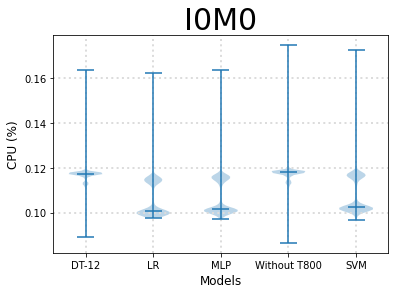

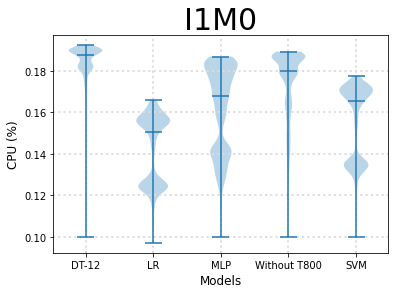

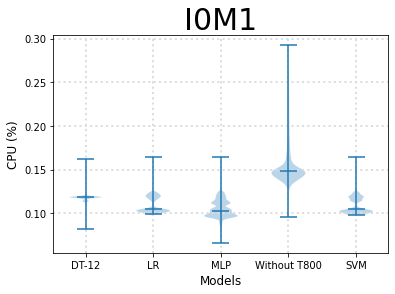

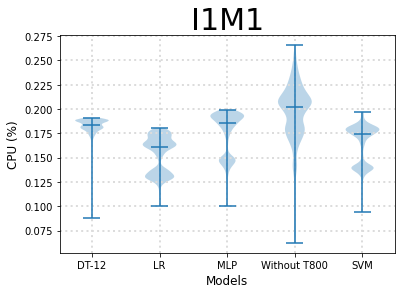

In [6]:
figs = experiments_suite.plot_experiments('CPU', 'CPU (%)')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_wifi.pdf')

I0M0
('A2', 'AL', 'AM', 'AN', 'AS')
[4116.0, 4116.0, 4116.0, 4116.0, 4116.0]
I1M0
('A2', 'AL', 'AM', 'AN', 'AS')
[4116.0, 4116.0, 4116.0, 4116.0, 4116.0]
I0M1
('A2', 'AL', 'AM', 'AN', 'AS')
[4116.0, 4116.0, 4116.0, 4116.0, 4116.0]
I1M1
('A2', 'AL', 'AM', 'AN', 'AS')
[4116.0, 4116.0, 4116.0, 4116.0, 4116.0]


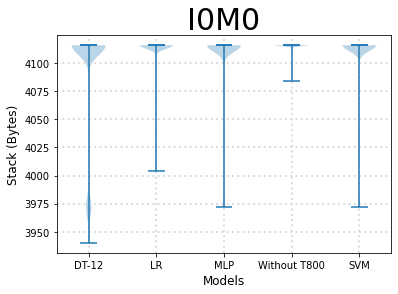

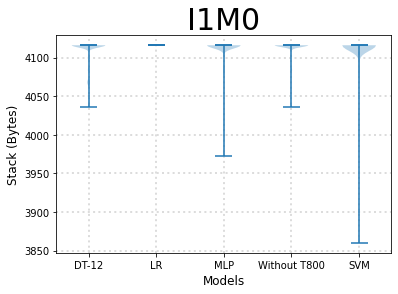

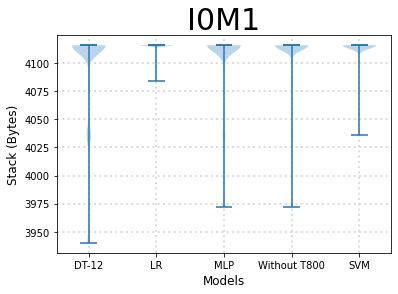

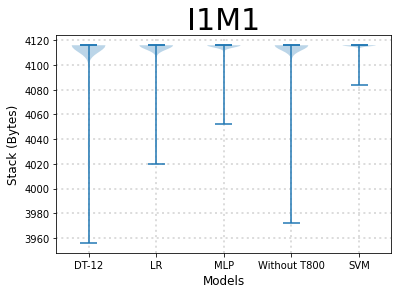

In [7]:
figs = experiments_suite.plot_experiments('Stack', 'Stack (Bytes)')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_stack.pdf')

I0M0
('A2', 'AL', 'AM', 'AN', 'AS')
[8.31, 8.35, 8.34, 8.26, 8.37]
I1M0
('A2', 'AL', 'AM', 'AN', 'AS')
[16.6, 14.02, 15.99, 16.54, 14.79]
I0M1
('A2', 'AL', 'AM', 'AN', 'AS')
[8.34, 8.35, 8.34, 8.39, 8.36]
I1M1
('A2', 'AL', 'AM', 'AN', 'AS')
[16.46, 13.82, 16.5, 15.91, 15.33]


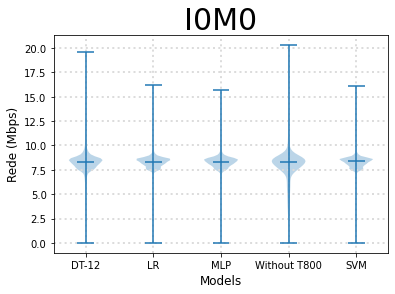

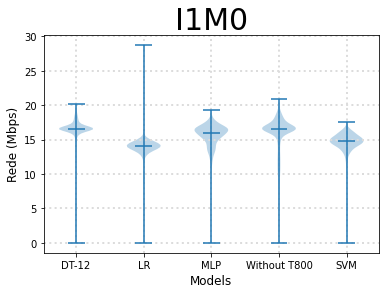

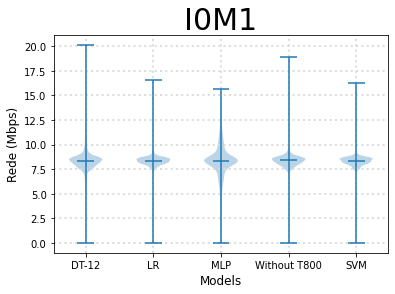

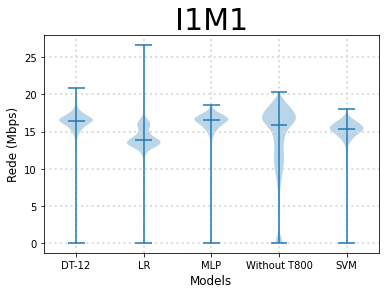

In [8]:
figs = experiments_suite.plot_experiments('Mbps', 'Rede (Mbps)')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_Mbps.pdf')

## Analsis of factors influence

In [9]:
all_models = ['N', 'M', '2', 'L', 'S']

importances = np.array([experiments_suite.get_factors_importance(i) for i in all_models])
importances = np.concatenate([importances, np.expand_dims(experiments_suite.get_factors_importance(None, agregate=True), axis=0)], axis=0)
x = np.round(pd.DataFrame(importances, index=['N', 'M', '2', 'L', 'S', 'Aggregate'], columns=['A', 'I', 'M', 'AI', 'AM', 'AM', 'AIM', 'Err']),2)
print(x)

(8, 352, 30)
(8, 30)
(8,)
0.2511259542988826
[0.         0.13015423 0.05730122 0.         0.         0.00740496
 0.        ]
(8, 352, 30)
(8, 30)
(8,)
0.2854093853801736
[0.03441212 0.17909655 0.02034363 0.00389739 0.00935972 0.00022005
 0.005072  ]
(8, 352, 30)
(8, 30)
(8,)
0.26408797198982015
[0.00762491 0.18970798 0.01362195 0.00559292 0.01504637 0.00245533
 0.00133231]
(8, 352, 30)
(8, 30)
(8,)
0.24600968911556986
[0.06725876 0.11334714 0.02206939 0.00058073 0.0082481  0.00088973
 0.0031611 ]
(8, 352, 30)
(8, 30)
(8,)
0.25457877574610777
[0.04423006 0.14636069 0.0195355  0.00047534 0.00992161 0.00075743
 0.00342584]
(8, 352, 30)
(8, 30)
(8,)
0.25320290848823834
[0.03445461 0.15562919 0.0187465  0.00113769 0.01049783 0.00092622
 0.00309339]
              A     I     M    AI    AM    AM   AIM   Err
N          0.00  0.52  0.23  0.00  0.00  0.03  0.00  0.22
M          0.12  0.63  0.07  0.01  0.03  0.00  0.02  0.12
2          0.03  0.72  0.05  0.02  0.06  0.01  0.01  0.11
L          0.2

In [10]:
print(np.sum(np.round(x, 2), axis=1))

N            1.00
M            1.00
2            1.01
L            0.98
S            0.99
Aggregate    0.98
dtype: float64
